# Classifying ALL with XGBoost and feature selection (ANOVA)

The subject of this notebook was to select K-best features with ANOVA and use XGBoost as the classifier. The parameter K (number of top features to select) was added to the parameter space together with XGBoost parameters. I was experimenting with different Optuna parameter spaces. The metrics that we used to find the best trial was f1_score. 

The best performing model was result of optimizing the parameter space #2 and using MinMaxScaler to preprocess data.


## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00


## Dependencies

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import joblib

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

## from sklearn.utils.fixes import loguniform
from scipy.stats import uniform, truncnorm, randint, loguniform

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Function for creating model pipelines - imblearn
## from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
## from imblearn.over_sampling import SMOTE

# Import XGBoost
from xgboost import XGBClassifier

# Import Optuna
import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback


import warnings
warnings.filterwarnings('ignore')

random_state = 10

In [4]:
# Import the script from different folder
import sys  
sys.path.append('/content/drive/MyDrive/Omdena/Team1/scripts')

import metrics_utilities as mu

## Batch_4 Train Dataset

In [5]:
df_train = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_4/train_data.pickle')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.185833,0.0,0.00000,0.000000,0.0,0.0,0.0,0.231458,0.0,0.0,...,0.545079,0.170755,0.0,0.096298,0.174819,0.0,0.0,0.361853,0.0,0
1,0.123157,0.0,0.56544,0.350086,0.0,0.0,0.0,0.228849,0.0,0.0,...,0.663390,0.115025,0.0,0.099379,0.516193,0.0,0.0,0.239392,0.0,1
2,0.197977,0.0,0.00000,0.000000,0.0,0.0,0.0,0.155163,0.0,0.0,...,0.663023,0.021846,0.0,0.000000,0.173690,0.0,0.0,0.270634,0.0,1
3,0.580151,0.0,0.00000,0.000000,0.0,0.0,0.0,0.298566,0.0,0.0,...,0.470815,0.000000,0.0,0.000000,0.118325,0.0,0.0,0.000000,0.0,0
4,0.066450,0.0,0.00000,0.000000,0.0,0.0,0.0,0.145156,0.0,0.0,...,0.645798,0.015262,0.0,0.027536,0.275665,0.0,0.0,0.000000,0.0,0


#### Separate features and labels

In [6]:
X_train = df_train.iloc[:, : -1]
y_train = df_train['label']
print(X_train.shape, y_train.shape)

(11917, 4608) (11917,)


## Batch_4 Test Dataset

In [7]:
df_test = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_4/test_data.pickle')
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.141500,0.0,0.000000,0.000000,0.0,0.0,0.0,0.151137,0.0,0.0,...,0.885778,0.066009,0.0,0.169458,0.570154,0.0,0.0,0.090579,0.0,0
1,0.047403,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.649062,0.260996,0.0,0.049776,0.494771,0.0,0.0,0.480568,0.0,0
2,0.000000,0.0,0.000000,0.023559,0.0,0.0,0.0,0.060329,0.0,0.0,...,0.725523,0.166289,0.0,0.131945,0.299330,0.0,0.0,0.000000,0.0,0
3,0.002286,0.0,0.655825,0.259398,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.626934,0.244303,0.0,0.100791,0.448022,0.0,0.0,0.295682,0.0,0
4,0.279953,0.0,0.000000,0.000000,0.0,0.0,0.0,0.168589,0.0,0.0,...,0.489483,0.166786,0.0,0.000000,0.212874,0.0,0.0,0.000000,0.0,0


#### Separate features and labels

In [8]:
X_test = df_test.iloc[:, :-1]
y_test = df_test['label']
print(X_test.shape, y_test.shape)

(1794, 4608) (1794,)


#### Names of Classes

In [9]:
target_names = ['hem', 'all']

# Fit the Base Model

In [10]:
# XGBoost static parameters
static_params = {
        'tree_method' : 'gpu_hist', 
        'gpu_id' : 0, 
        'objective' : 'binary:logistic', 
        'eval_metric' : 'auc', 
        'random_state' : random_state
}

In [11]:
# define the pipeline to evaluate
clf = XGBClassifier(**static_params)
pipe = Pipeline(steps=[('xgb', clf)])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, gpu_id=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=10, ...))])

In [ ]:
pipe.get_params()

{'memory': None,
 'steps': [('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric='auc', feature_types=None,
                 gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=10, ...))],
 'verbose': False,
 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytre

In [ ]:
# Save the model
joblib.dump(pipe, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_base.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_base.save']

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.8494983277591973

In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8494983277591973


In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 237,  102],
       [ 168, 1287]])

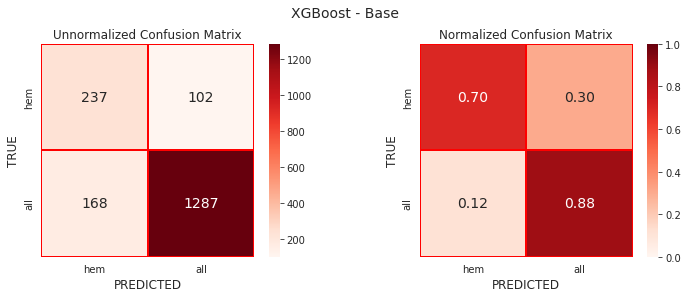

In [ ]:
# Plot confusion matrices
mu.plot_cm_unnorm_and_norm('XGBoost - Base', y_test, y_pred, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.59      0.70      0.64       339
         all       0.93      0.88      0.91      1455

    accuracy                           0.85      1794
   macro avg       0.76      0.79      0.77      1794
weighted avg       0.86      0.85      0.85      1794



# Optuna & Feature Selection - GPU #1

### Define the Pipeline

In [ ]:
# define the pipeline to evaluate
fs = SelectKBest(score_func=f_classif) # ANOVA feature selection
pipe = Pipeline(steps=[('anova',fs), ('xgb', clf)])

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'anova__k' : trial.suggest_int('anova__k', 100, X_train.shape[1]), 
        'xgb__max_depth': trial.suggest_int('xgb__max_depth', 1, 9),
        'xgb__learning_rate': trial.suggest_loguniform('xgb__learning_rate', 0.01, 1.0),
        'xgb__n_estimators': trial.suggest_int('xgb__n_estimators', 50, 500),
        'xgb__min_child_weight': trial.suggest_int('xgb__min_child_weight', 1, 10),
        'xgb__gamma': trial.suggest_loguniform('xgb__gamma', 1e-8, 1.0),
        'xgb__subsample': trial.suggest_loguniform('xgb__subsample', 0.01, 1.0),
        'xgb__colsample_bytree': trial.suggest_loguniform('xgb__colsample_bytree', 0.01, 1.0),
        'xgb__reg_alpha': trial.suggest_loguniform('xgb__reg_alpha', 1e-8, 1.0),
        'xgb__reg_lambda': trial.suggest_loguniform('xgb__reg_lambda', 1e-8, 1.0)
    }


    # Fit the model
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-18 03:38:44,648] A new study created in memory with name: no-name-7f2cc97b-80b4-4175-b690-34e8dfb0b865


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-18 03:39:05,088] Trial 0 finished with value: 0.7649980894153611 and parameters: {'anova__k': 2440, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.7705471097824109, 'xgb__n_estimators': 69, 'xgb__min_child_weight': 7, 'xgb__gamma': 0.0020044045062336553, 'xgb__subsample': 0.028377930966438546, 'xgb__colsample_bytree': 0.031144623308900925, 'xgb__reg_alpha': 0.025404715420823645, 'xgb__reg_lambda': 1.2438168367464724e-08}. Best is trial 0 with value: 0.7649980894153611.
[I 2023-04-18 03:39:06,535] Trial 1 finished with value: 0.8161764705882353 and parameters: {'anova__k': 624, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.7454140575892694, 'xgb__n_estimators': 308, 'xgb__min_child_weight': 6, 'xgb__gamma': 0.00021493114453194378, 'xgb__subsample': 0.021481776911077975, 'xgb__colsample_bytree': 0.09280658178525404, 'xgb__reg_alpha': 0.053854597896876535, 'xgb__reg_lambda': 0.4494265732845531}. Best is trial 1 with value: 0.8161764705882353.
[I 2023-04-18 03:39:13,980] Trial 2 fi

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.9166954718285516
  Params: 
    anova__k: 2389
    xgb__max_depth: 9
    xgb__learning_rate: 0.04531421088653614
    xgb__n_estimators: 469
    xgb__min_child_weight: 1
    xgb__gamma: 1.9676826641224828e-08
    xgb__subsample: 0.7938448033825015
    xgb__colsample_bytree: 0.054364826782738025
    xgb__reg_alpha: 0.002778558526027052
    xgb__reg_lambda: 1.4511032865288804e-08


## Re-fit the model

In [ ]:
params = trial.params

pipe.set_params(**params)
pipe.fit(X_train, y_train)

Pipeline(steps=[('anova', SelectKBest(k=2389)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.054364826782738025,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=1.9676826641224828e-08,
                               gpu_id=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.04531421088653614, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=469,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=10, ...))])

In [ ]:
# Save the model
joblib.dump(pipe, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_1.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_1.save']

In [ ]:
y_pred_fs = pipe.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_fs)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.57


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8656633221850614


In [ ]:
cm = confusion_matrix(y_test, y_pred_fs)
print(cm)

[[ 227  112]
 [ 129 1326]]


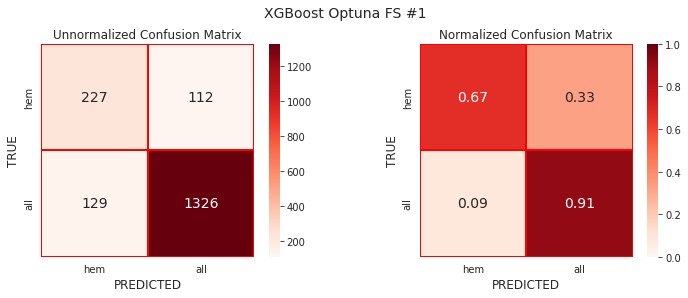

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Optuna FS #1', y_test, y_pred_fs, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_fs, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.64      0.67      0.65       339
         all       0.92      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.78      0.79      0.78      1794
weighted avg       0.87      0.87      0.87      1794



# Optuna & Feature Selection - GPU #2

### Define the Pipeline

In [ ]:
# define the pipeline to evaluate
fs = SelectKBest(score_func=f_classif) # ANOVA feature selection
pipe = Pipeline(steps=[('anova',fs), ('xgb', clf)])

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'anova__k' : trial.suggest_int('anova__k', 100, X_train.shape[1]), 
        'xgb__max_depth': trial.suggest_int('xgb__max_depth', 4, 14), # changed
        'xgb__learning_rate': trial.suggest_loguniform('xgb__learning_rate', 0.01, 1.0),
        'xgb__n_estimators': trial.suggest_int('xgb__n_estimators', 150, 600), # changed
        'xgb__min_child_weight': trial.suggest_int('xgb__min_child_weight', 1, 10),
        'xgb__gamma': trial.suggest_loguniform('xgb__gamma', 1e-8, 1.0),
        'xgb__subsample': trial.suggest_loguniform('xgb__subsample', 0.01, 1.0),
        'xgb__colsample_bytree': trial.suggest_loguniform('xgb__colsample_bytree', 0.01, 1.0),
        'xgb__reg_alpha': trial.suggest_loguniform('xgb__reg_alpha', 1e-8, 1.0),
        'xgb__reg_lambda': trial.suggest_loguniform('xgb__reg_lambda', 1e-8, 1.0)
    }


    # Fit the model
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-18 04:34:06,910] A new study created in memory with name: no-name-6d10a268-9fb9-4f78-a041-7edf4466f9a9


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=200)

[I 2023-04-18 04:34:24,962] Trial 0 finished with value: 0.8853146853146853 and parameters: {'anova__k': 4010, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.013168551200113237, 'xgb__n_estimators': 560, 'xgb__min_child_weight': 7, 'xgb__gamma': 1.2692606799904852e-06, 'xgb__subsample': 0.09534381303164424, 'xgb__colsample_bytree': 0.08363179627203148, 'xgb__reg_alpha': 1.823553462066478e-05, 'xgb__reg_lambda': 0.03549922371997502}. Best is trial 0 with value: 0.8853146853146853.
[I 2023-04-18 04:34:29,469] Trial 1 finished with value: 0.8801973220577871 and parameters: {'anova__k': 1172, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.010417294389970147, 'xgb__n_estimators': 346, 'xgb__min_child_weight': 8, 'xgb__gamma': 0.0010617944765656182, 'xgb__subsample': 0.056691155462821725, 'xgb__colsample_bytree': 0.4731775728984896, 'xgb__reg_alpha': 5.968885770275308e-06, 'xgb__reg_lambda': 2.316316924473097e-07}. Best is trial 0 with value: 0.8853146853146853.
[I 2023-04-18 04:34:36,978] Trial

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 200
Best trial:
  Value: 0.9214260989961924
  Params: 
    anova__k: 2515
    xgb__max_depth: 13
    xgb__learning_rate: 0.060919269243350206
    xgb__n_estimators: 526
    xgb__min_child_weight: 3
    xgb__gamma: 1.1381582744144766e-07
    xgb__subsample: 0.9971790010921209
    xgb__colsample_bytree: 0.33747116032051566
    xgb__reg_alpha: 8.5872597769116e-08
    xgb__reg_lambda: 0.0004645667810571595


## Re-fit the model

In [ ]:
params = trial.params

pipe.set_params(**params)
pipe.fit(X_train, y_train)

Pipeline(steps=[('anova', SelectKBest(k=2515)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.33747116032051566,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=1.1381582744144766e-07,
                               gpu_id=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.060919269243350206, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=13,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, n_estimators=526,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=10, ...))])

In [ ]:
# Save the model
joblib.dump(pipe, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_2.save')

In [ ]:
y_pred_fs = pipe.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_fs)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 87.35


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8734671125975474


In [ ]:
cm = confusion_matrix(y_test, y_pred_fs)
print(cm)

[[ 236  103]
 [ 124 1331]]


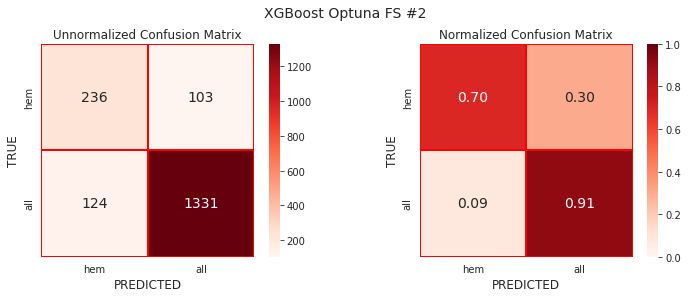

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Optuna FS #2', y_test, y_pred_fs, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_fs, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.66      0.70      0.68       339
         all       0.93      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.79      0.81      0.80      1794
weighted avg       0.88      0.87      0.87      1794



# Optuna & Feature Selection - GPU #2 - scaled

### Define the Pipeline

In [13]:
# define the pipeline to evaluate
fs = SelectKBest(score_func=f_classif) # ANOVA feature selection
pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                       ('anova',fs), 
                       ('xgb', clf)])

## Optuna Objective Function

In [26]:
def objective(trial):
    """Define the objective function"""

    params = {
        'anova__k' : trial.suggest_int('anova__k', 0.2*X_train.shape[1], X_train.shape[1], 10), 
        'xgb__max_depth': trial.suggest_int('xgb__max_depth', 4, 14), # changed
        'xgb__learning_rate': trial.suggest_loguniform('xgb__learning_rate', 0.01, 1.0),
        'xgb__n_estimators': trial.suggest_int('xgb__n_estimators', 150, 600), # changed
        'xgb__min_child_weight': trial.suggest_int('xgb__min_child_weight', 1, 10),
        'xgb__gamma': trial.suggest_loguniform('xgb__gamma', 1e-8, 1.0),
        'xgb__subsample': trial.suggest_loguniform('xgb__subsample', 0.01, 1.0),
        'xgb__colsample_bytree': trial.suggest_loguniform('xgb__colsample_bytree', 0.01, 1.0),
        'xgb__reg_alpha': trial.suggest_loguniform('xgb__reg_alpha', 1e-8, 1.0),
        'xgb__reg_lambda': trial.suggest_loguniform('xgb__reg_lambda', 1e-8, 1.0)
    }


    # Fit the model
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [27]:
study = optuna.create_study(direction='maximize')

[I 2023-04-21 19:54:16,014] A new study created in memory with name: no-name-3cef5255-01ad-4b2f-89aa-4c4c8f47d608


## Optimize the Objective Function

In [28]:
study.optimize(objective, n_trials=120)

[I 2023-04-21 19:54:39,381] Trial 0 finished with value: 0.8463513017968463 and parameters: {'anova__k': 4011, 'xgb__max_depth': 13, 'xgb__learning_rate': 0.07885395567135156, 'xgb__n_estimators': 177, 'xgb__min_child_weight': 7, 'xgb__gamma': 0.003220786426587577, 'xgb__subsample': 0.012295888848437814, 'xgb__colsample_bytree': 0.687897722170438, 'xgb__reg_alpha': 2.6565332703195416e-07, 'xgb__reg_lambda': 0.001692089705408774}. Best is trial 0 with value: 0.8463513017968463.
[I 2023-04-21 19:54:45,379] Trial 1 finished with value: 0.8258780036968576 and parameters: {'anova__k': 1211, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.20898545769444335, 'xgb__n_estimators': 539, 'xgb__min_child_weight': 8, 'xgb__gamma': 0.0032929984456173365, 'xgb__subsample': 0.060582631412688465, 'xgb__colsample_bytree': 0.3237713809450368, 'xgb__reg_alpha': 8.66334081691633e-05, 'xgb__reg_lambda': 2.709406282825047e-07}. Best is trial 0 with value: 0.8463513017968463.
[I 2023-04-21 19:54:53,114] Trial 2

## Best Parameters

In [29]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 120
Best trial:
  Value: 0.9197080291970803
  Params: 
    anova__k: 4111
    xgb__max_depth: 8
    xgb__learning_rate: 0.0484776017019965
    xgb__n_estimators: 567
    xgb__min_child_weight: 1
    xgb__gamma: 0.02558537656231033
    xgb__subsample: 0.8318428408705691
    xgb__colsample_bytree: 0.868101059433309
    xgb__reg_alpha: 1.7939502336897113e-06
    xgb__reg_lambda: 7.303929289215537e-06


## Re-fit the model

In [30]:
params = trial.params

pipe.set_params(**params)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('anova', SelectKBest(k=4111)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.868101059433309,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=0.02558537656231033,
                               gpu_id=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0484776017019965, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=567,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=10, ...))])

In [31]:
# Save the model
joblib.dump(pipe, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_2_mms.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_2_mms.save']

In [32]:
y_pred_fs = pipe.predict(X_test)

In [33]:
accuracy = accuracy_score(y_test, y_pred_fs)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 87.12


In [34]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8712374581939799


In [35]:
cm = confusion_matrix(y_test, y_pred_fs)
print(cm)

[[ 240   99]
 [ 132 1323]]


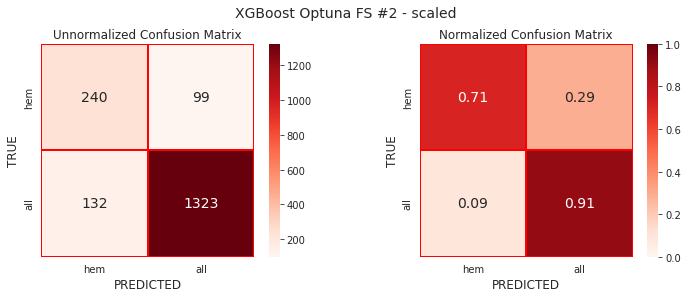

In [36]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Optuna FS #2 - scaled', y_test, y_pred_fs, target_names, 'Reds')

In [37]:
print(classification_report(y_test, y_pred_fs, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.65      0.71      0.68       339
         all       0.93      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.79      0.81      0.80      1794
weighted avg       0.88      0.87      0.87      1794



# Optuna & Feature Selection - GPU #3 - pruned

### Define the Pipeline

In [73]:
# define the pipeline to evaluate
clf = XGBClassifier(**static_params, verbosity=0)
fs = SelectKBest(score_func=f_classif) # ANOVA feature selection
pipe = Pipeline(steps=[('anova',fs), 
                       ('xgb', clf)])

## Optuna Objective Function

In [77]:
def objective(trial):
    """Define the objective function"""

    params = {
        'anova__k' : trial.suggest_int('anova__k', 900, X_train.shape[1]), 
        'xgb__max_depth': trial.suggest_int('xgb__max_depth', 4, 14), # changed
        'xgb__learning_rate': trial.suggest_loguniform('xgb__learning_rate', 0.01, 1.0),
        'xgb__n_estimators': trial.suggest_int('xgb__n_estimators', 150, 600), # changed
        'xgb__min_child_weight': trial.suggest_int('xgb__min_child_weight', 1, 10),
        'xgb__gamma': trial.suggest_loguniform('xgb__gamma', 1e-8, 1.0),
        'xgb__subsample': trial.suggest_loguniform('xgb__subsample', 0.01, 1.0),
        'xgb__colsample_bytree': trial.suggest_loguniform('xgb__colsample_bytree', 0.01, 1.0),
        'xgb__reg_alpha': trial.suggest_loguniform('xgb__reg_alpha', 1e-8, 1.0),
        'xgb__reg_lambda': trial.suggest_loguniform('xgb__reg_lambda', 1e-8, 1.0)
    }

    pruning_callback = XGBoostPruningCallback(trial, "validation_0-auc")
                  
    pipe.set_params(**params)

    pipe['anova'].fit(X_train, y_train)
    X_train_fs = pipe['anova'].transform(X_train)
    X_test_fs = pipe['anova'].transform(X_test)

    pipe['xgb'].fit(X_train_fs, y_train, callbacks=[pruning_callback], eval_set=[(X_test_fs, y_test)])

    # Make predictions
    y_pred = pipe.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [78]:
study = optuna.create_study(direction='maximize', pruner = optuna.pruners.MedianPruner(n_warmup_steps=5))

[I 2023-04-22 00:01:32,082] A new study created in memory with name: no-name-592664be-57c6-41c1-8171-c6bb70764232


## Optimize the Objective Function

In [79]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[157]	validation_0-auc:0.79477
[158]	validation_0-auc:0.79419
[159]	validation_0-auc:0.79463
[160]	validation_0-auc:0.79438
[161]	validation_0-auc:0.79536
[162]	validation_0-auc:0.79595
[163]	validation_0-auc:0.79645
[164]	validation_0-auc:0.79692
[165]	validation_0-auc:0.79654
[166]	validation_0-auc:0.79652
[167]	validation_0-auc:0.79685
[168]	validation_0-auc:0.79703
[169]	validation_0-auc:0.79791
[170]	validation_0-auc:0.79851
[171]	validation_0-auc:0.79891
[172]	validation_0-auc:0.79836
[173]	validation_0-auc:0.79871
[174]	validation_0-auc:0.79844
[175]	validation_0-auc:0.79789
[176]	validation_0-auc:0.79752
[177]	validation_0-auc:0.79825
[178]	validation_0-auc:0.79901
[179]	validation_0-auc:0.79912
[180]	validation_0-auc:0.80087
[181]	validation_0-auc:0.80220
[182]	validation_0-auc:0.80286
[183]	validation_0-auc:0.80272
[184]	validation_0-auc:0.80375
[185]	validation_0-auc:0.80476
[186]	validation_0-auc:0.80430
[187]	validation_0-

XGBoostError: ignored

## Best Parameters

In [80]:
trial = 0.9172724125995153 

parameters = {'anova__k': 2015, 
              'xgb__max_depth': 14, 
              'xgb__learning_rate': 0.07260837345353795, 
              'xgb__n_estimators': 478, 
              'xgb__min_child_weight': 2, 
              'xgb__gamma': 0.007083736663756101, 
              'xgb__subsample': 0.6907912539301014, 
              'xgb__colsample_bytree': 0.2192424139019541, 
              'xgb__reg_alpha': 0.03326872881504368, 
              'xgb__reg_lambda': 2.7426273390847665e-08}

In [81]:
print(f'Number of finished trials: 26')
print('Best trial:')

print(f'  Value: {trial}')
print('  Params: ')

for key, value in parameters.items():
    print(f'    {key}: {value}')

Number of finished trials: 26
Best trial:
  Value: 0.9172724125995153
  Params: 
    anova__k: 2015
    xgb__max_depth: 14
    xgb__learning_rate: 0.07260837345353795
    xgb__n_estimators: 478
    xgb__min_child_weight: 2
    xgb__gamma: 0.007083736663756101
    xgb__subsample: 0.6907912539301014
    xgb__colsample_bytree: 0.2192424139019541
    xgb__reg_alpha: 0.03326872881504368
    xgb__reg_lambda: 2.7426273390847665e-08


## Re-fit the model

In [82]:
params = parameters

pipe.set_params(**params)
pipe.fit(X_train, y_train)

Pipeline(steps=[('anova', SelectKBest(k=2015)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.2192424139019541,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=0.007083736663756101,
                               gpu_id=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07260837345353795, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=14,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, n_estimators=478,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=10, ...))])

In [83]:
# Save the model
joblib.dump(pipe, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_3.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_3.save']

In [84]:
y_pred_fs = pipe.predict(X_test)

In [85]:
accuracy = accuracy_score(y_test, y_pred_fs)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.68


In [86]:
# Compare training and testing scores
print(f"Training Data Score: {pipe.score(X_train, y_train)}")
print(f"Testing Data Score: {pipe.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.866778149386845


In [87]:
cm = confusion_matrix(y_test, y_pred_fs)
print(cm)

[[ 230  109]
 [ 130 1325]]


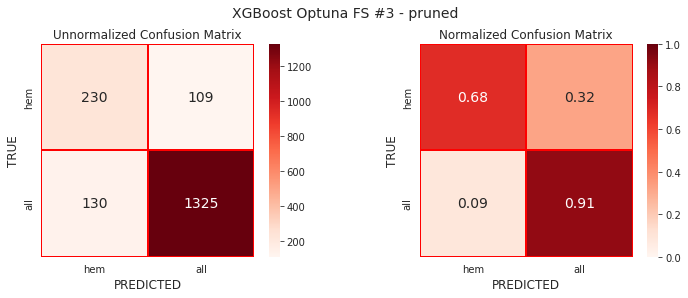

In [104]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('XGBoost Optuna FS #3 - pruned', y_test, y_pred_fs, target_names, 'Reds')

In [89]:
print(classification_report(y_test, y_pred_fs, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.64      0.68      0.66       339
         all       0.92      0.91      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.78      0.79      0.79      1794
weighted avg       0.87      0.87      0.87      1794



# Comparison

In [ ]:
xgb = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_base.save')
y_pred_base = xgb.predict(X_test)
xgb_opt1 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_1.save')
y_pred1 = xgb_opt1.predict(X_test)
xgb_opt2 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_2.save')
y_pred2 = xgb_opt2.predict(X_test)
xgb_opt2_mms = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_2_mms.save')
y_pred2_mms = xgb_opt2_mms.predict(X_test)
xgb_opt3 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_3.save')
y_pred3 = xgb_opt3.predict(X_test)

In [18]:
pred_d = {'XGBoost - Base' : y_pred_base,
          'XGBoost Optuna FS #1' : y_pred1,
          'XGBoost - Optuna FS #2' : y_pred2,
          'XGBoost - Optuna FS #2 - scaled' : y_pred2_mms,
          'XGBoost - Optuna FS #3 - pruned' : y_pred3
}

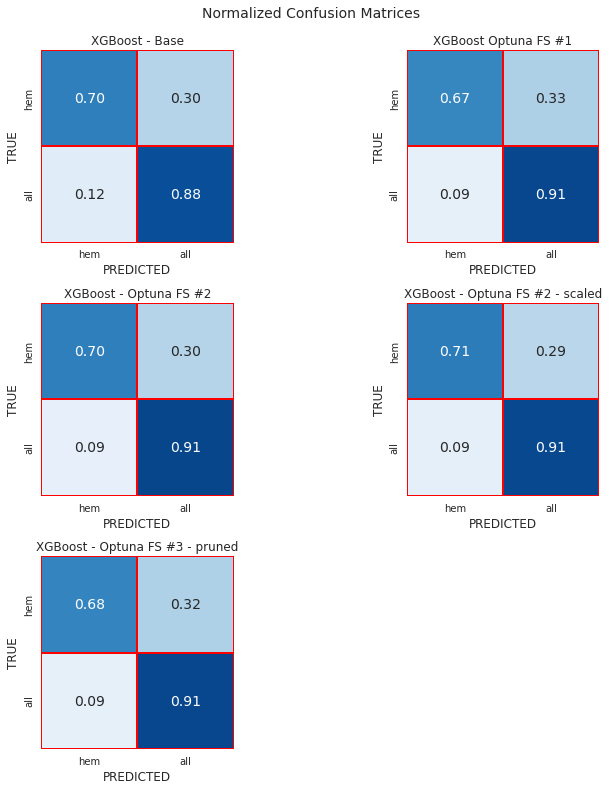

In [19]:
# Plot all confusion matrices - normalized
mu.plot_conf_matrices(pred_d, y_test, target_names, 'Blues')

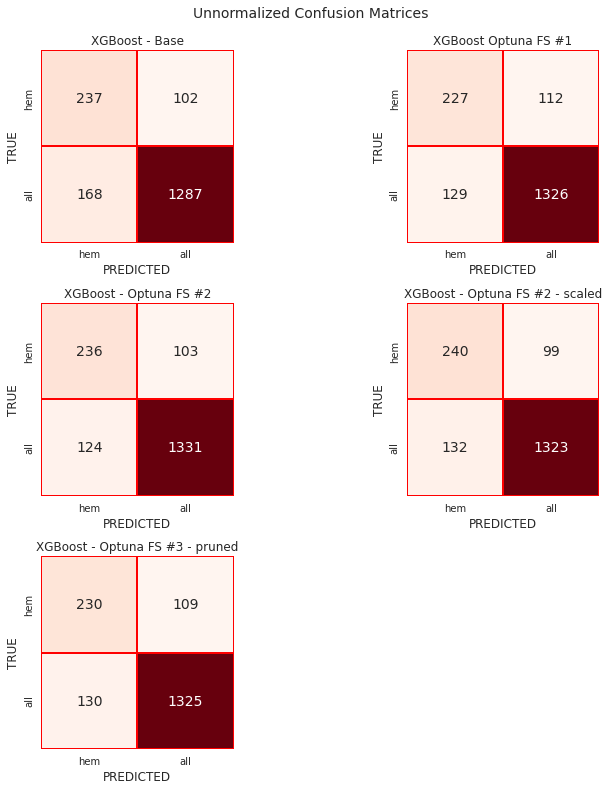

In [20]:
# Plot all confusion matrices - unnormalized
mu.plot_conf_matrices(pred_d, y_test, target_names, 'Reds', norm=False)

## Plot ROC Curves

In [ ]:
# Load best performing models
xgb_opt2 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_2.save')
xgb_opt2_mms = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_fs/xgb_opt_fs_2_mms.save')

In [21]:
# Best performing models dictionary
best_models = {'XGBoost - Optuna FS #2' : xgb_opt2,
               'XGBoost - Optuna FS #2 - scaled' : xgb_opt2_mms
}

#### Create function to plot ROC curves for train and test data

In [23]:
def plot_roc_curves(model_name, model, batch, X_train, X_test, y_train, y_test):
    fig, [ax_train, ax_test] = plt.subplots(1, 2, figsize=(11, 5))
    fig.suptitle(f'{model_name}', fontsize=14)
    
    pred_train = model.predict(X_train)
    pred_test= model.predict(X_test)
    auc_train = roc_auc_score(y_train, pred_train)
    auc_test = roc_auc_score(y_test, pred_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, pred_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, pred_test)

    ax_train.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    ax_test.plot([0, 1], [0, 1], 'r--', label='Random Guessing')

    ax_train.plot(fpr_train, tpr_train, label=f'{model_name} (AUC: {auc_train:.2f})')
    ax_test.plot(fpr_test, tpr_test, label=f'{model_name} (AUC: {auc_test:.4f})')

    ax_train.set_title(f'ROC curve - Train Data - {batch}')
    ax_test.set_title(f'ROC curve - Test Data- {batch}')
                    
    ax_train.set_xlabel('False positive rate')
    ax_test.set_xlabel('False positive rate')

    ax_train.set_ylabel('True positive rate')
    ax_test.set_ylabel('True positive rate')

    ax_train.legend(loc='best')
    ax_test.legend(loc='best')

    plt.show()
    print()

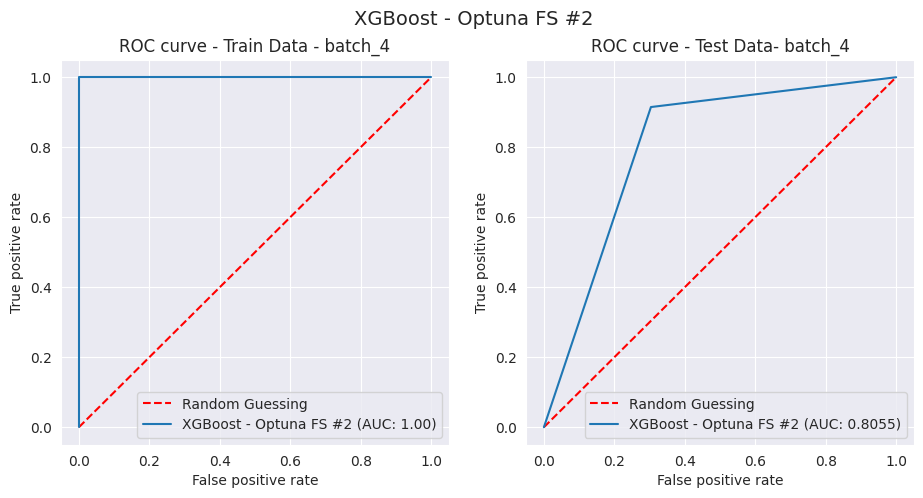

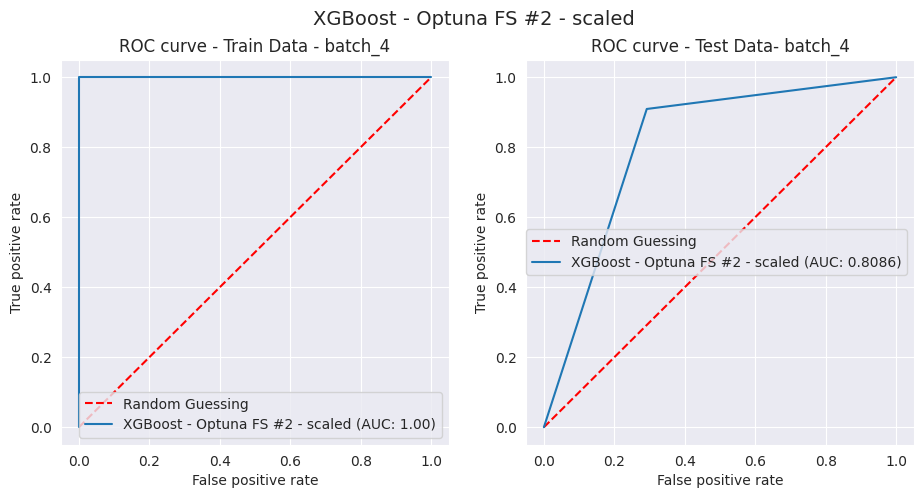

In [25]:
# Plot ROC curves for each of best performing models
for mn, m in best_models.items():
    plot_roc_curves(mn, m, 'batch_4', X_train, X_test, y_train, y_test)